## Imported packages

In [ ]:
!pip install efficientnet

import os
import math
import pandas as pd
from scipy.io import loadmat
from random import randrange
import numpy as np
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import l2

import efficientnet.keras as efn

%matplotlib inline

In [ ]:
!pip install pyyaml h5py  

## Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Connect to TPU

In [ ]:
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)
strategy = tf.distribute.experimental.TPUStrategy(resolver)

INFO:tensorflow:Initializing the TPU system: grpc://10.46.2.130:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.46.2.130:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


## Read TFRecords, Generate, Augment and Normalize Images

In [ ]:
def custom_image_generator(lists, batch_size, mode="train", aug=None):
    while True:
        images = []
        make_ids = []
        model_ids = []
        
        while len(images) < batch_size:
            random_idx = randrange(len(lists[0]))
            img = load_img(lists[0][random_idx], target_size=(IMAGE_SIZE[0], IMAGE_SIZE[1]))
            img = img_to_array(img)
            # TODO: Center crop instead of resize
            images.append(img)
            make_ids.append(lists[1][random_idx])
            model_ids.append(lists[2][random_idx])
        
        labels = [np.array(make_ids),np.array(model_ids)]
        
        if aug:
            (images, labels) = next(aug.flow(np.array(images), labels, batch_size=batch_size))
        
        yield np.array(images),  labels 

def read_tfrecord(example):
  features = {
      "image": tf.io.FixedLenFeature([], tf.string),
      "make_id": tf.io.FixedLenFeature([], tf.int64),
      "make_id_oh": tf.io.VarLenFeature(tf.float32),
      "model_id": tf.io.FixedLenFeature([], tf.int64),
      "model_id_oh": tf.io.VarLenFeature(tf.float32)
  }

  feature = tf.io.parse_single_example(example, features)

  image = tf.image.decode_jpeg(feature['image'], channels=3)
  image = tf.image.convert_image_dtype(image, tf.float32)
  image = tf.image.resize(image, [*IMAGE_SIZE])

  make_id_oh = tf.sparse.to_dense(feature['make_id_oh'])
  make_id_oh = tf.reshape(make_id_oh, [163])
  print(make_id_oh.shape)

  model_id_oh = tf.sparse.to_dense(feature['model_id_oh'])
  model_id_oh = tf.reshape(model_id_oh, [1716])
  print(model_id_oh.shape)

  return image, {'make_id': make_id_oh, 'model_id': model_id_oh}

def augment(image, labels):
  image = tf.image.random_crop(image, size=[64, 224, 224, 3]) # Random crop back
  image = tf.image.random_brightness(image, max_delta=0.6) # Random brightness
  image = tf.image.random_flip_left_right(image)
  image = tf.image.random_contrast(image, 0.2, 0.6)
  # image = tf.image.random_jpeg_quality(image, 10, 80)
  image = tf.image.random_saturation(image, 5, 35)
  image = tf.image.random_hue(image, 0.2)
  print(labels)

  return image, labels

def normalise(image, labels):
  image = tf.cast(image, tf.float32) * (1. / 255)
  print(labels)

  return image, labels

## Function to Build Baseline Model

In [ ]:
def build_model(model_version, lr, losses, metrics):
  if model_version == 0:
    base_model = efn.EfficientNetB0(include_top=False, weights='noisy-student')
  elif model_version == 1:
    base_model = efn.EfficientNetB1(include_top=False, weights='noisy-student')
  elif model_version == 2:
    base_model = efn.EfficientNetB2(include_top=False, weights='noisy-student')
  elif model_version == 3:
    base_model = efn.EfficientNetB3(include_top=False, weights='noisy-student')
  elif model_version == 4:
    base_model = efn.EfficientNetB4(include_top=False, weights='noisy-student')
  else:
    base_model = efn.EfficientNetB5(include_top=False, weights='noisy-student')
  
  for layer in base_model.layers:
      layer.trainable = True

  model_input = Input(shape=[IMAGE_SIZE[0],IMAGE_SIZE[1],3])
  x = base_model(model_input)
  x = GlobalAveragePooling2D()(x)
  
  x = Dense(256, activation='relu')(x)
  x = Dropout(0.25)(x)
  x = Dense(256, activation='relu')(x)
  x = Dropout(0.25)(x)
  
  y1 = Dense(128, activation='relu')(x)
  y1 = Dropout(0.25)(y1)
  y1 = Dense(64, activation='relu')(y1)
  y1 = Dropout(0.25)(y1)
  
  y2 = Dense(128, activation='relu')(x)
  y2 = Dropout(0.25)(y2)
  y2 = Dense(64, activation='relu')(y2)
  y2 = Dropout(0.25)(y2)
  
  y1 = Dense(163, activation='softmax', name='make_id')(y1)
  y2 = Dense(1716, activation='softmax', name='model_id')(y2)
  
  model = Model(inputs=model_input, outputs=[y1, y2])
  
  model.compile(loss=losses, optimizer=SGD(lr=lr, momentum=0.9), metrics=metrics)
  
  return model

## Read Labels Dataframe

In [ ]:
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/CZ4042 Project/df.csv')

In [ ]:
df = pd.read_csv('/content/drive/My Drive/CZ4042 Project/df.csv') 

In [ ]:
!ls 'drive/MyDrive/CZ4042_Project/dataset/'

df.csv


In [ ]:
df = pd.read_csv('drive/MyDrive/CZ4042_Project/dataset/df.csv') # Sam's path

In [ ]:
df.head()

,filename,make_id,model_id
0,data/image/135/947/2009/deab76f22e8937.jpg,135,947
1,data/image/135/947/2009/b00fef3e12bdf0.jpg,135,947
2,data/image/135/947/2009/69ada64edf3ebb.jpg,135,947
3,data/image/135/947/2009/60b5fa727f82f2.jpg,135,947
4,data/image/135/947/2009/83ce148be0dcb5.jpg,135,947


## Make ID Count and Plot of Counts for Each Make ID

In [ ]:
df_make_id_unique = df.make_id.unique() ## Abstract make ID uniques values
print('Sorted Unique Value from Make ID')
print(sorted(df_make_id_unique))
print('Maximum Values of Make ID')
print(max(df_make_id_unique))
print('Minimum Value of Make ID')
print(min(df_make_id_unique))
num_make_id_unique = len(df_make_id_unique)
print('Total Number Of Make Unique IDs')
print(num_make_id_unique)

Sorted Unique Value from Make ID
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163]
Maximum Values of Make ID
163
Minimum Value of Make ID
1
Total Number Of Make Unique IDs
163


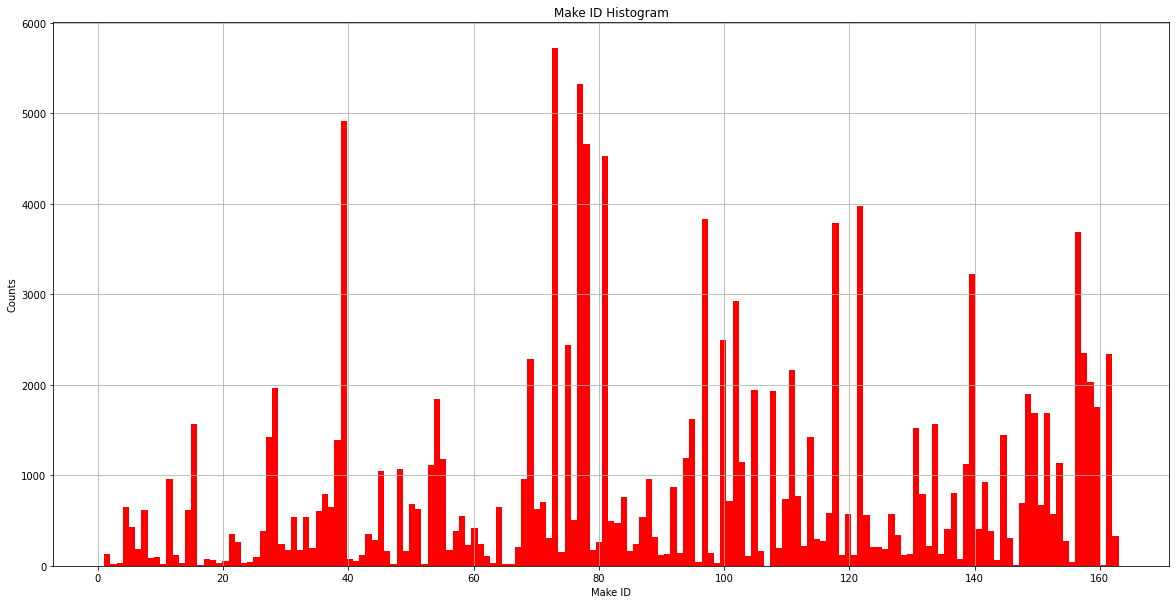

In [ ]:
plt.figure(figsize=(20,10))
plt.title("Make ID Histogram")
plt.ylabel('Counts')
plt.xlabel('Make ID')
df.make_id.hist(bins= num_make_id_unique,  color='red')

## Model ID Count and Plot of Counts for Each Model ID

In [ ]:
df_model_id_unique = df.model_id.unique() ## Abstract model ID uniques values
print('Sorted Unique Value from Model ID')
print(sorted(df_model_id_unique))
print('Maximum Value of Model ID')
print(max(df_model_id_unique))
print('Minimum Value of Model ID')
print(min(df_model_id_unique))
num_model_id_unique = len(df_model_id_unique)
print('Total Number Of Model Unique IDs')
print(num_model_id_unique)

Sorted Unique Value from Model ID
[1, 2, 3, 4, 5, 9, 11, 12, 13, 14, 15, 16, 17, 18, 19, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 34, 35, 36, 38, 39, 40, 41, 42, 43, 44, 46, 47, 48, 49, 50, 52, 53, 55, 56, 57, 60, 61, 62, 63, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 81, 82, 83, 84, 85, 86, 87, 88, 89, 91, 92, 93, 94, 95, 96, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 112, 113, 114, 115, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 152, 153, 154, 156, 157, 158, 159, 160, 161, 162, 163, 164, 167, 168, 169, 170, 174, 175, 176, 178, 179, 180, 181, 182, 183, 184, 185, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 200, 201, 202, 204, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 221, 222, 223, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 239, 240, 241, 242, 243, 247, 248, 249, 250, 251, 252

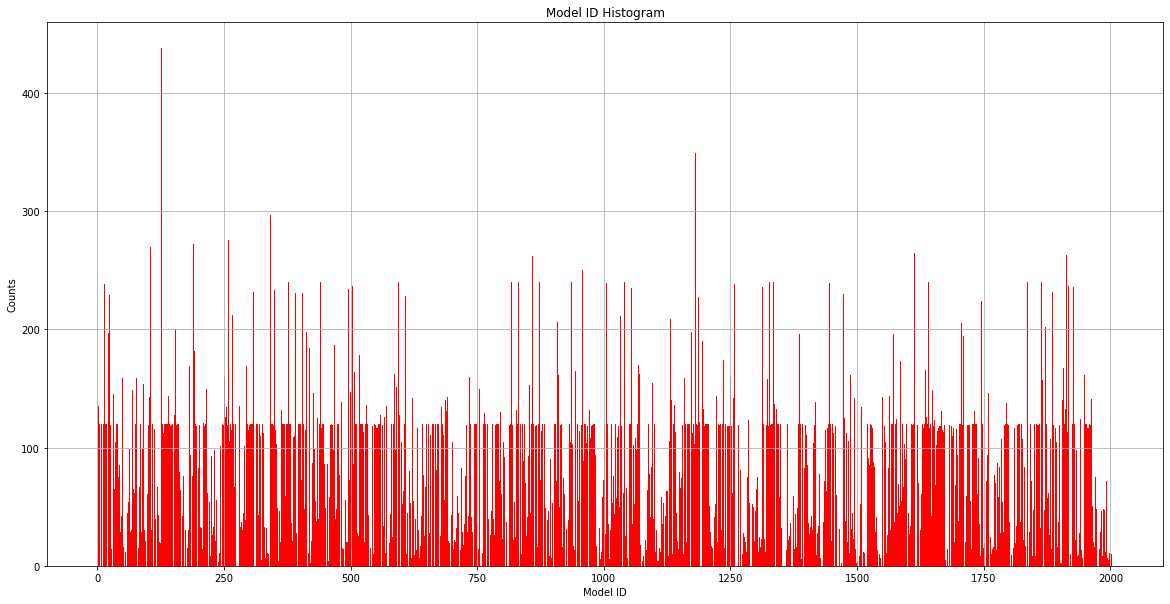

In [ ]:
plt.figure(figsize=(20,10))
plt.title("Model ID Histogram")
plt.ylabel('Counts')
plt.xlabel('Model ID')
df.model_id.hist(bins=num_model_id_unique, color='red')

## Load TFRecords for Training and Validation Datasets

In [ ]:
IMAGE_SIZE = [224,224]
BATCH_SIZE = 64
GCS_PATH = 'gs://compcars'
tfrecord_train_dir = GCS_PATH + '/train'
tfrecord_val_dir = GCS_PATH + '/val'

option_no_order = tf.data.Options()
option_no_order.experimental_deterministic = False
AUTO = tf.data.experimental.AUTOTUNE

train_path = tf.io.gfile.glob(tfrecord_train_dir + "/*.tfrec")
val_path = tf.io.gfile.glob(tfrecord_val_dir + "/*.tfrec")

training_dataset = tf.data.TFRecordDataset(train_path, num_parallel_reads=AUTO)
training_dataset = training_dataset.with_options(option_no_order)
training_dataset = training_dataset.repeat()
training_dataset = training_dataset.shuffle(1000 + 3*BATCH_SIZE)
training_dataset = training_dataset.map(read_tfrecord, num_parallel_calls=AUTO)
training_dataset = training_dataset.batch(BATCH_SIZE)
training_dataset = training_dataset.map(augment, num_parallel_calls=AUTO)
training_dataset = training_dataset.map(normalise, num_parallel_calls=AUTO)
training_dataset = training_dataset.prefetch(AUTO)

val_dataset = tf.data.TFRecordDataset(val_path, num_parallel_reads=AUTO)
val_dataset = val_dataset.with_options(option_no_order)
val_dataset = val_dataset.map(read_tfrecord, num_parallel_calls=AUTO)
val_dataset = val_dataset.batch(BATCH_SIZE)
val_dataset = val_dataset.map(augment, num_parallel_calls=AUTO)
val_dataset = val_dataset.map(normalise, num_parallel_calls=AUTO)
val_dataset = val_dataset.cache()
val_dataset = val_dataset.prefetch(AUTO)


(163,)
(1716,)
{'make_id': <tf.Tensor 'args_1:0' shape=(None, 163) dtype=float32>, 'model_id': <tf.Tensor 'args_2:0' shape=(None, 1716) dtype=float32>}
{'make_id': <tf.Tensor 'args_1:0' shape=(None, 163) dtype=float32>, 'model_id': <tf.Tensor 'args_2:0' shape=(None, 1716) dtype=float32>}
(163,)
(1716,)
{'make_id': <tf.Tensor 'args_1:0' shape=(None, 163) dtype=float32>, 'model_id': <tf.Tensor 'args_2:0' shape=(None, 1716) dtype=float32>}
{'make_id': <tf.Tensor 'args_1:0' shape=(None, 163) dtype=float32>, 'model_id': <tf.Tensor 'args_2:0' shape=(None, 1716) dtype=float32>}


In [ ]:
for image in training_dataset.unbatch().take(1):
  print(image)

(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
array([[[1.5506775e-03, 1.1995111e-03, 0.0000000e+00],
        [1.5506775e-03, 1.1995111e-03, 0.0000000e+00],
        [1.5506775e-03, 1.1995111e-03, 0.0000000e+00],
        ...,
        [1.4552219e-03, 1.5713016e-03, 4.0379426e-04],
        [1.4157464e-03, 1.5243010e-03, 3.4875204e-04],
        [1.3313867e-03, 1.4324251e-03, 2.4884415e-04]],

       [[1.5554961e-03, 1.2032385e-03, 0.0000000e+00],
        [1.5554961e-03, 1.2032385e-03, 0.0000000e+00],
        [1.5554961e-03, 1.2032385e-03, 0.0000000e+00],
        ...,
        [4.5664163e-04, 1.0837535e-03, 0.0000000e+00],
        [5.1607209e-04, 1.2164074e-03, 0.0000000e+00],
        [5.4764515e-04, 1.2821221e-03, 0.0000000e+00]],

       [[1.5603148e-03, 1.2069689e-03, 0.0000000e+00],
        [1.5603148e-03, 1.2069689e-03, 0.0000000e+00],
        [1.5603148e-03, 1.2069689e-03, 0.0000000e+00],
        ...,
        [5.4542418e-04, 1.5223881e-03, 0.0000000e+00],
        [5.5061566e-0

## Define Learning Rate Curve

In [ ]:
def lr_curve(epoch):
  if (epoch < 5):
    return 1e-6 + epoch*((1e-1-1e-6)/6)

  initial_lrate = 1e-1
  k = 0.1
  lrate = initial_lrate * math.exp(-k*epoch)

  return lrate

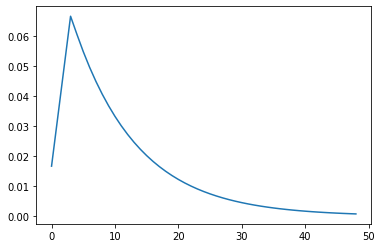

In [ ]:
plt.plot([lr_curve(i) for i in range(1,50)])

In [ ]:
def lr_curve_alt(epoch):

  initial_lrate = 1e-1
  k = 0.1
  lrate = initial_lrate * math.exp(-k*(epoch+70))

  return lrate

## Build Baseline EfficientNetB5 Model

In [ ]:
with strategy.scope():
  model = build_model(
            5,
            1e-6,
            ['categorical_crossentropy', 'categorical_crossentropy'], 
            {'make_id':'accuracy', 'model_id':'accuracy'}
    )
model.summary()

115261440/115255328 [==============================] - 2s 0us/step
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
efficientnet-b5 (Functional)    (None, None, None, 2 28513520    input_2[0][0]                    
__________________________________________________________________________________________________
global_average_pooling2d (Globa (None, 2048)         0           efficientnet-b5[0][0]            
__________________________________________________________________________________________________
dense (Dense)                   (None, 256)          524544      global_average_pooling2d[0][0]   
____________________

## Training Baseline Model

### First 20 epochs

In [ ]:
with strategy.scope():
  checkpoint = ModelCheckpoint('/content/drive/My Drive/CZ4042 Project/model_checkpoints/ckpt-{epoch}-augment.h5', 
                              monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=True, mode='min')
  steps_per_epoch=(0.675*len(df)) // BATCH_SIZE
  validation_steps=(0.225*len(df)) // BATCH_SIZE

  history = model.fit(
      training_dataset,
      steps_per_epoch=steps_per_epoch,
      validation_data=val_dataset,
      validation_steps=validation_steps,
      epochs=20,
      callbacks=[checkpoint, LearningRateScheduler(lr_curve)]
  )

Epoch 1/20
Instructions for updating:
Use `tf.data.Iterator.get_next_as_optional()` instead.


Instructions for updating:
Use `tf.data.Iterator.get_next_as_optional()` instead.


   2/1442 [..............................] - ETA: 2:16 - loss: 12.5277 - make_id_loss: 5.0825 - model_id_loss: 7.4452 - make_id_accuracy: 0.0234 - model_id_accuracy: 0.0000e+00WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0146s vs `on_train_batch_end` time: 0.1677s). Check your callbacks.


1442/1442 [==============================] - ETA: 0s - loss: 12.5385 - make_id_loss: 5.0894 - model_id_loss: 7.4491 - make_id_accuracy: 0.0086 - model_id_accuracy: 5.3095e-04WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0084s vs `on_test_batch_end` time: 0.0604s). Check your callbacks.


1442/1442 [==============================] - 332s 230ms/step - loss: 12.5385 - make_id_loss: 5.0894 - model_id_loss: 7.4491 - make_id_accuracy: 0.0086 - model_id_accuracy: 5.3095e-04 - val_loss: 13.8774 - val_make_id_loss: 5.8479 - val_model_id_loss: 8.0295 - val_make_id_accuracy: 0.0076 - val_model_id_accuracy: 7.4870e-04
Epoch 2/20
1442/1442 [==============================] - 290s 201ms/step - loss: 11.7300 - make_id_loss: 4.4352 - model_id_loss: 7.2948 - make_id_accuracy: 0.0448 - model_id_accuracy: 0.0018 - val_loss: 44.8023 - val_make_id_loss: 16.9720 - val_model_id_loss: 27.8302 - val_make_id_accuracy: 0.0652 - val_model_id_accuracy: 0.0042
Epoch 3/20
1442/1442 [==============================] - 296s 206ms/step - loss: 10.4326 - make_id_loss: 3.9364 - model_id_loss: 6.4962 - make_id_accuracy: 0.0909 - model_id_accuracy: 0.0083 - val_loss: 10.8332 - val_make_id_loss: 4.2248 - val_model_id_loss: 6.6084 - val_make_id_accuracy: 0.1083 - val_model_id_accuracy: 0.0124
Epoch 4/20
1442/1

### Save Model for first 20 Epochs

In [ ]:
model.save('/content/drive/My Drive/CZ4042 Project/model_checkpoints/first20.h5')

### Save Training History for first 20 Epochs

In [ ]:
# convert the history.history dict to a pandas DataFrame:     
hist_df = pd.DataFrame(history.history) 

# or save to csv: 
hist_csv_file = '/content/drive/My Drive/CZ4042 Project/history.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

### Load Model Trained for 40 Epochs

In [ ]:
with strategy.scope():
  model = tf.keras.models.load_model('/content/drive/My Drive/CZ4042 Project/model_checkpoints/40epochs.h5')

### Train Model Trained for 40 Epochs

In [ ]:
#with strategy.scope():
checkpoint = ModelCheckpoint('/content/drive/My Drive/CZ4042 Project/model_checkpoints/ckpt-{epoch} + 40 -augment.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')

history = model.fit(
    training_dataset,
    steps_per_epoch=(0.675*len(df)) // BATCH_SIZE,
    validation_data=val_dataset,
    validation_steps=(0.225*len(df)) // BATCH_SIZE,
    epochs=20,
    callbacks=[checkpoint, LearningRateScheduler(lr_curve_alt)]
)

Epoch 1/20
Instructions for updating:
Use `tf.data.Iterator.get_next_as_optional()` instead.


Instructions for updating:
Use `tf.data.Iterator.get_next_as_optional()` instead.


   2/1442 [..............................] - ETA: 2:17 - loss: 1.9132 - make_id_loss: 0.3834 - model_id_loss: 1.5298 - make_id_accuracy: 0.9297 - model_id_accuracy: 0.4922WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0143s vs `on_train_batch_end` time: 0.1690s). Check your callbacks.


1442/1442 [==============================] - ETA: 0s - loss: 2.0955 - make_id_loss: 0.5297 - model_id_loss: 1.5658 - make_id_accuracy: 0.8419 - model_id_accuracy: 0.4924WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0083s vs `on_test_batch_end` time: 0.0550s). Check your callbacks.



Epoch 00001: val_loss improved from inf to 1.83094, saving model to /content/drive/My Drive/CZ4042 Project/model_checkpoints/ckpt-1 + 40 -augment.h5
1442/1442 [==============================] - 330s 229ms/step - loss: 2.0955 - make_id_loss: 0.5297 - model_id_loss: 1.5658 - make_id_accuracy: 0.8419 - model_id_accuracy: 0.4924 - val_loss: 1.8309 - val_make_id_loss: 0.5418 - val_model_id_loss: 1.2891 - val_make_id_accuracy: 0.8607 - val_model_id_accuracy: 0.6060
Epoch 2/20
1442/1442 [==============================] - ETA: 0s - loss: 2.0695 - make_id_loss: 0.5206 - model_id_loss: 1.5489 - make_id_accuracy: 0.8429 - model_id_accuracy: 0.4954
Epoch 00002: val_loss improved from 1.83094 to 1.81496, saving model to /content/drive/My Drive/CZ4042 Project/model_checkpoints/ckpt-2 + 40 -augment.h5
1442/1442 [==============================] - 291s 202ms/step - loss: 2.0695 - make_id_loss: 0.5206 - model_id_loss: 1.5489 - make_id_accuracy: 0.8429 - model_id_accuracy: 0.4954 - val_loss: 1.8150 - va

### Save Model Trained for 60 Epochs

In [ ]:
model.save('/content/drive/My Drive/CZ4042 Project/model_checkpoints/60epochs.h5')

### Save Training History for Epochs 40 to 60

In [ ]:
# convert the history.history dict to a pandas DataFrame:     
hist_df = pd.DataFrame(history.history) 

# or save to csv: 
hist_csv_file = '/content/drive/My Drive/CZ4042 Project/history3.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

### Load Model Trained for 70 Epochs

In [ ]:
with strategy.scope():
  model = tf.keras.models.load_model('/content/drive/My Drive/CZ4042 Project/model_checkpoints/70epochs.h5')

### Train Model Trained for 70 Epochs

In [ ]:
#with strategy.scope():
checkpoint = ModelCheckpoint('/content/drive/My Drive/CZ4042 Project/model_checkpoints/ckpt-{epoch} + 70 -augment.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')

history = model.fit(
    training_dataset,
    steps_per_epoch=(0.675*len(df)) // BATCH_SIZE,
    validation_data=val_dataset,
    validation_steps=(0.225*len(df)) // BATCH_SIZE,
    epochs=10,
    callbacks=[checkpoint, LearningRateScheduler(lr_curve_alt)]
)

Epoch 1/10
   2/1442 [..............................] - ETA: 2:08 - loss: 1.5894 - make_id_loss: 0.3055 - model_id_loss: 1.2839 - make_id_accuracy: 0.9062 - model_id_accuracy: 0.5859WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0133s vs `on_train_batch_end` time: 0.1587s). Check your callbacks.


1442/1442 [==============================] - ETA: 0s - loss: 1.8471 - make_id_loss: 0.4374 - model_id_loss: 1.4097 - make_id_accuracy: 0.8678 - model_id_accuracy: 0.5321WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0083s vs `on_test_batch_end` time: 0.0534s). Check your callbacks.



Epoch 00001: val_loss improved from inf to 1.66571, saving model to /content/drive/My Drive/CZ4042 Project/model_checkpoints/ckpt-1 + 70 -augment.h5
1442/1442 [==============================] - 310s 215ms/step - loss: 1.8471 - make_id_loss: 0.4374 - model_id_loss: 1.4097 - make_id_accuracy: 0.8678 - model_id_accuracy: 0.5321 - val_loss: 1.6657 - val_make_id_loss: 0.4893 - val_model_id_loss: 1.1764 - val_make_id_accuracy: 0.8773 - val_model_id_accuracy: 0.6454
Epoch 2/10
1442/1442 [==============================] - ETA: 0s - loss: 1.8365 - make_id_loss: 0.4344 - model_id_loss: 1.4020 - make_id_accuracy: 0.8677 - model_id_accuracy: 0.5364
Epoch 00002: val_loss did not improve from 1.66571
1442/1442 [==============================] - 292s 202ms/step - loss: 1.8365 - make_id_loss: 0.4344 - model_id_loss: 1.4020 - make_id_accuracy: 0.8677 - model_id_accuracy: 0.5364 - val_loss: 1.6671 - val_make_id_loss: 0.4898 - val_model_id_loss: 1.1773 - val_make_id_accuracy: 0.8775 - val_model_id_accur

In [ ]:
# convert the history.history dict to a pandas DataFrame:     
hist_df = pd.DataFrame(history.history) 

# or save to csv: 
hist_csv_file = '/content/drive/My Drive/CZ4042 Project/history5.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

### Save Final Baseline Model trained for 80 Epochs

In [ ]:
model.save('/content/drive/My Drive/CZ4042 Project/model_checkpoints/80epochs.h5')

### Load Training History of Baseline Model Trained for 80 Epochs

In [ ]:
hist = pd.read_csv('/content/drive/MyDrive/CZ4042 Project/Final Baseline Model/history-baseline.csv')
hist.head()

,loss,make_id_loss,model_id_loss,make_id_accuracy,model_id_accuracy,val_loss,val_make_id_loss,val_model_id_loss,val_make_id_accuracy,val_model_id_accuracy,lr
0,12.538518,5.089414,7.449109,0.008647,0.000531,13.877374,5.847881,8.029495,0.007650,0.000749,0.000001
1,11.729980,4.435192,7.294781,0.044773,0.001810,44.802292,16.972048,27.830217,0.065169,0.004199,0.016668
2,10.432603,3.936415,6.496190,0.090911,0.008257,10.833235,4.224797,6.608431,0.108268,0.012370,0.033334
3,9.496766,3.621469,5.875292,0.141123,0.016795,9.405162,3.627796,5.777365,0.143522,0.023210,0.050000
4,9.026561,3.462269,5.564294,0.170748,0.025009,9.377220,3.586780,5.790445,0.168685,0.029883,0.066667


In [ ]:
print(history.keys())

dict_keys(['loss', 'make_id_loss', 'model_id_loss', 'make_id_accuracy', 'model_id_accuracy', 'val_loss', 'val_make_id_loss', 'val_model_id_loss', 'val_make_id_accuracy', 'val_model_id_accuracy', 'lr'])


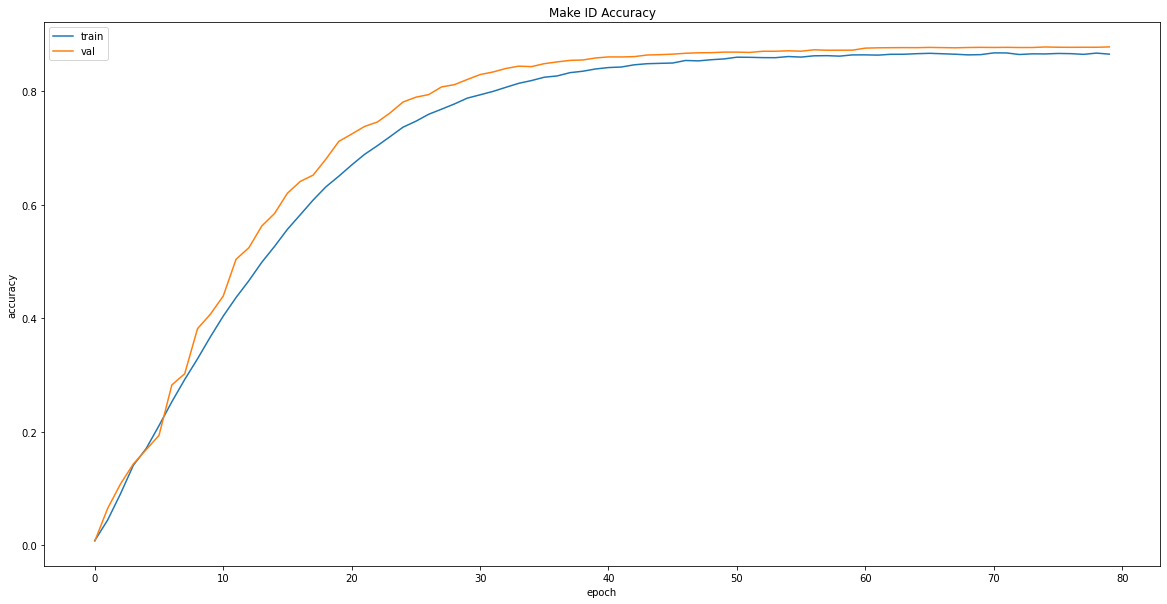

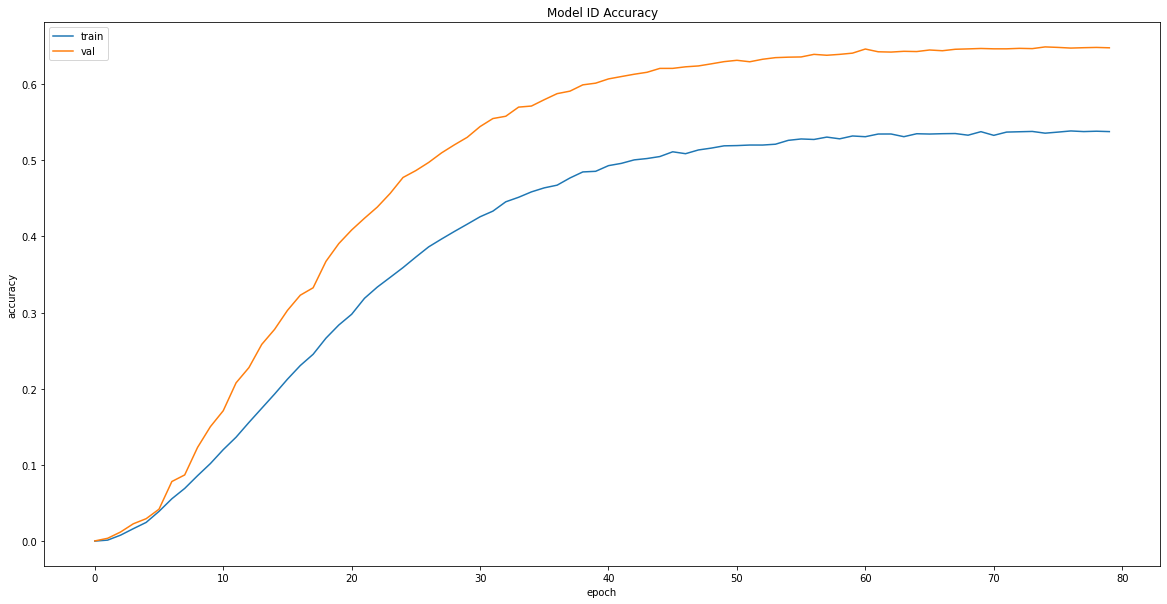

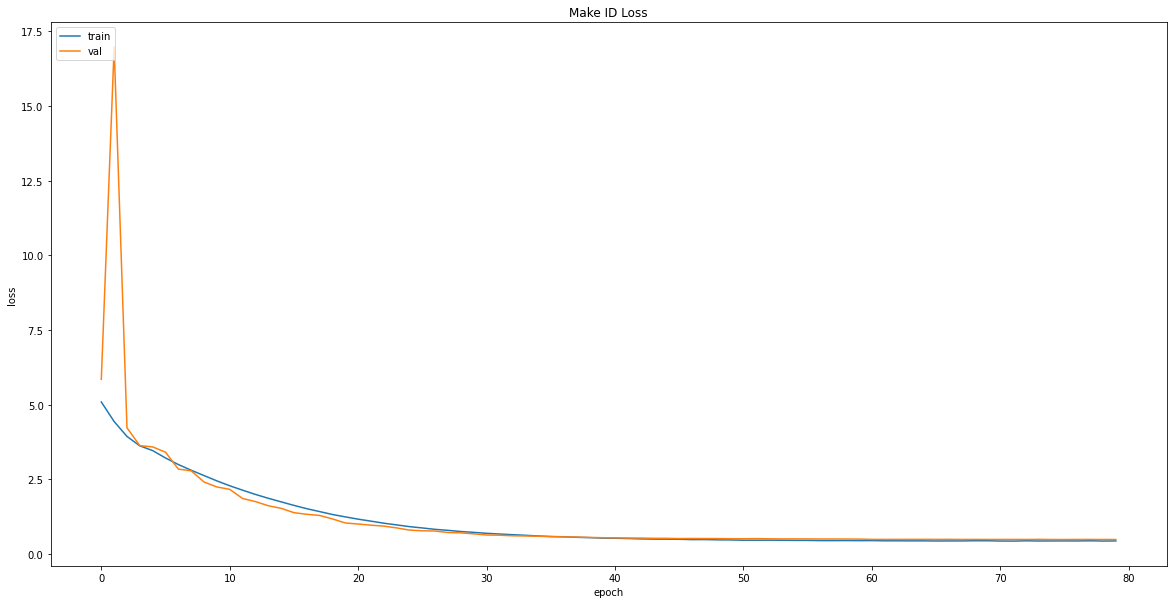

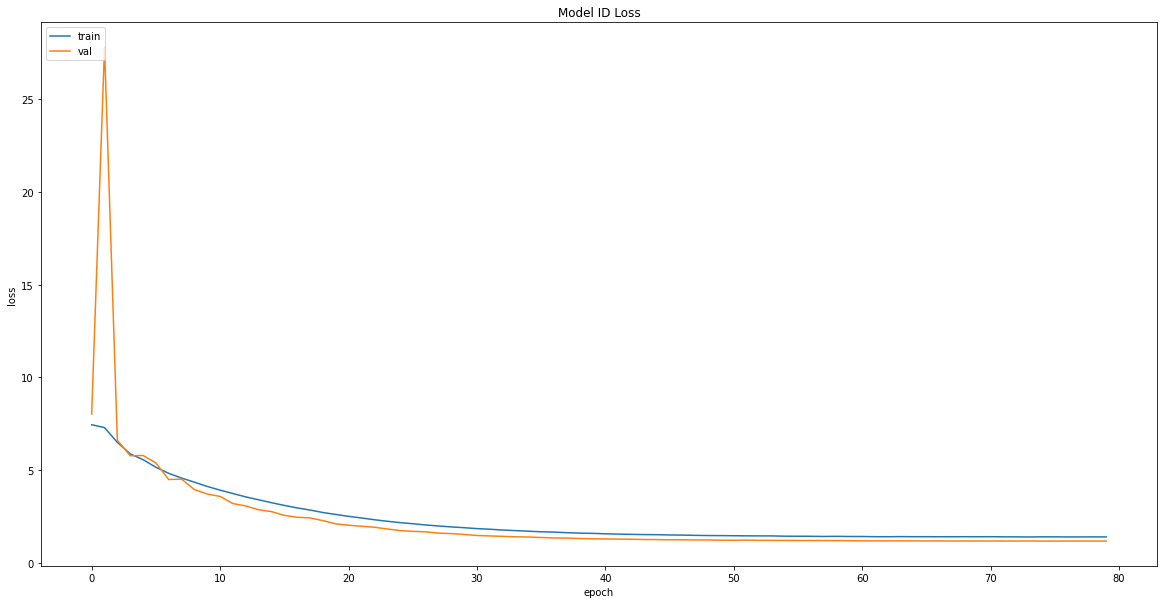

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(hist['make_id_accuracy'].values)
plt.plot(hist['val_make_id_accuracy'].values)
plt.title('Make ID Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(hist['model_id_accuracy'].values)
plt.plot(hist['val_model_id_accuracy'].values)
plt.title('Model ID Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(hist['make_id_loss'].values)
plt.plot(hist['val_make_id_loss'].values)
plt.title('Make ID Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(hist['model_id_loss'].values)
plt.plot(hist['val_model_id_loss'].values)
plt.title('Model ID Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Evaluate model on TestSet

In [ ]:
def custom_image_generator(lists, batch_size, mode="train", aug=None):
    while True:
        images = []
        make_ids = []
        model_ids = []
        
        while len(images) < batch_size:
            random_idx = randrange(len(lists[0]))
            img = load_img(lists[0][random_idx], target_size=(IMAGE_SIZE[0], IMAGE_SIZE[1]))
            img = img_to_array(img)
            # TODO: Center crop instead of resize
            images.append(img)
            make_ids.append(lists[1][random_idx])
            model_ids.append(lists[2][random_idx])
        
        labels = [np.array(make_ids),np.array(model_ids)]
        
        if aug:
            (images, labels) = next(aug.flow(np.array(images), labels, batch_size=batch_size))
        
        yield np.array(images),  labels 

def read_tfrecord(example):
  features = {
      "image": tf.io.FixedLenFeature([], tf.string),
      "make_id": tf.io.FixedLenFeature([], tf.int64),
      "make_id_oh": tf.io.VarLenFeature(tf.float32),
      "model_id": tf.io.FixedLenFeature([], tf.int64),
      "model_id_oh": tf.io.VarLenFeature(tf.float32)
  }

  feature = tf.io.parse_single_example(example, features)

  image = tf.image.decode_jpeg(feature['image'], channels=3)
  image = tf.image.convert_image_dtype(image, tf.float32)
  image = tf.image.resize(image, [*IMAGE_SIZE])

  make_id_oh = tf.sparse.to_dense(feature['make_id_oh'])
  make_id_oh = tf.reshape(make_id_oh, [163])
  print(make_id_oh.shape)

  model_id_oh = tf.sparse.to_dense(feature['model_id_oh'])
  model_id_oh = tf.reshape(model_id_oh, [1716])
  print(model_id_oh.shape)

  return image, {'make_id': make_id_oh, 'model_id': model_id_oh}

def augment(image, labels):
  image = tf.image.random_crop(image, size=[64, 224, 224, 3]) # Random crop back
  image = tf.image.random_brightness(image, max_delta=0.6) # Random brightness
  image = tf.image.random_flip_left_right(image)
  image = tf.image.random_contrast(image, 0.2, 0.6)
  # image = tf.image.random_jpeg_quality(image, 10, 80)
  image = tf.image.random_saturation(image, 5, 35)
  image = tf.image.random_hue(image, 0.2)
  print(labels)

  return image, labels

def normalise(image, labels):
  image = tf.cast(image, tf.float32) * (1. / 255)
  print(labels)

  return image, labels

def get_x(image, labels):
  return image

def get_y(image, labels):
  return labels

In [ ]:
IMAGE_SIZE = [224,224]
BATCH_SIZE = 64
GCS_PATH = 'gs://compcars'
tfrecord_test_dir = GCS_PATH + '/test'

option_no_order = tf.data.Options()
option_no_order.experimental_deterministic = False
AUTO = tf.data.experimental.AUTOTUNE

test_path = tf.io.gfile.glob(tfrecord_test_dir + "/*.tfrec")

test_dataset = tf.data.TFRecordDataset(test_path, num_parallel_reads=AUTO)
test_dataset = test_dataset.with_options(option_no_order)
test_dataset = test_dataset.map(read_tfrecord, num_parallel_calls=AUTO)
test_dataset = test_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.map(augment, num_parallel_calls=AUTO)
test_dataset = test_dataset.map(normalise, num_parallel_calls=AUTO)
test_dataset = test_dataset.cache()
test_dataset = test_dataset.prefetch(AUTO)

(163,)
(1716,)
{'make_id': <tf.Tensor 'args_1:0' shape=(None, 163) dtype=float32>, 'model_id': <tf.Tensor 'args_2:0' shape=(None, 1716) dtype=float32>}
{'make_id': <tf.Tensor 'args_1:0' shape=(None, 163) dtype=float32>, 'model_id': <tf.Tensor 'args_2:0' shape=(None, 1716) dtype=float32>}


In [ ]:
with strategy.scope():
  model = tf.keras.models.load_model('/content/drive/MyDrive/CZ4042 Project/model_checkpoints/80epochs.h5')

In [ ]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(test_dataset)
print("test loss, test acc:", results)

Evaluate on test data
215/215 [==============================] - 16s 73ms/step - loss: 1.9821 - make_id_loss: 0.5410 - model_id_loss: 1.4412 - make_id_accuracy: 0.8730 - model_id_accuracy: 0.6408
test loss, test acc: [1.9821497201919556, 0.5409506559371948, 1.441198706626892, 0.8729650974273682, 0.6408430337905884]


# Optimal Hyperparameter Search

## Install New Packages

In [ ]:
!pip install -q -U keras-tuner
!pip install efficientnet

     |████████████████████████████████| 71kB 4.0MB/s 


## Imported Required Packages

In [ ]:
# Import Various Libraries required for further preprocessing and neural network model
## Models Libraries
import tensorflow as tf                                 # Tensorflow operation
from keras.layers import Dense                          # Neural Network Layer operation
from keras.optimizers import SGD                        # SGD Optimizer operation
from keras.layers import Dropout                        # Use Dropout mechanism
from keras.layers import GlobalAveragePooling2D         # Use Average Pooling mechanism
from keras import Input                                 # Use Input mechanism
from keras import Model                                 # Use Model mechanism
from keras.callbacks import Callback                    # Implement time taken per epoch
from keras.callbacks import EarlyStopping               # Stop training if no improvement in validation loss
from keras.optimizers import Adam                       # Use Adam for Optimizer
from sklearn.model_selection import train_test_split
import pandas as pd                                     # Read the respective data
import efficientnet.keras as efn                        # Import trained model
from kerastuner.tuners import Hyperband                 # Implement randomsearch mechanism
from kerastuner.tuners import RandomSearch              # Implement randomsearch mechanism
import kerastuner as kt                                 # Utilize keras tuner for optimal hyperparameter search
import IPython                                          # A kernel for Jupyter for interactive data visualization
import os                                               # Get datasets
from google.colab import drive                          # Read one drive files  
from google.colab import auth                           # Enabled authorization
import cv2 as cv                                        # Image manipulation
import numpy as np                                      # Manipulate data
import time                                             # Elapsed Time
auth.authenticate_user()

## Directory and Model Settings 

In [ ]:
# Directory Setting
path_y = 'drive/MyDrive/CV4042_Project/dataset/'
path_x = 'drive/MyDrive/CV4042_Project/dataset/images/'
#path_opt = 'drive/MyDrive/CV4042_Project/tuner_cache/'
path_opt = 'gs://cz4042nn' # To TPU
filename = 'df_test.csv'

In [ ]:
# Integrity Checks
df = pd.read_csv(path_y + filename) 

In [ ]:
df.head(10)

,filename,make_id,model_id
0,data/image/135/947/2009/deab76f22e8937.jpg,135,947
1,data/image/135/947/2009/b00fef3e12bdf0.jpg,135,947
2,data/image/135/947/2009/69ada64edf3ebb.jpg,135,947
3,data/image/135/947/2009/60b5fa727f82f2.jpg,135,947
4,data/image/135/947/2009/83ce148be0dcb5.jpg,135,947
5,data/image/135/947/2009/13916301245610.jpg,135,947
6,data/image/135/947/2009/6c0b42e75ca247.jpg,135,947
7,data/image/135/947/2009/26eeecb834a607.jpg,135,947
8,data/image/135/947/2009/6eb62be44a79c6.jpg,135,947
9,data/image/135/947/2009/6c21604f0ee59f.jpg,135,947


In [ ]:
# Declaration
IMAGE_SIZE = [224,224]
DIM = (224,224)
EPOCHSLIMIT = 5
SEED = 0
LAYER_OFFSET = [0,1,2,3,4,5]
SPLITRATIO = 0.2                          # Test set
EARLYSTOPPER = 5
BATCH_SIZE = 64

NEURONS = [64,128,256,512,1024] 
LAYERS = [1,2,3,4,5]
DROPOUTS = [0.0,0.1,0.2,0.3,0.4]
LEARNRATE = [1e-2,1e-3,1e-4,1e-5,1e-6]

MAKE_COUNT  = 163
MODEL_COUNT = 1716

## Functions for Optimal Hyperparameter Search

In [ ]:
# Clear Training Output during search operation
class ClearTrainingOutput(Callback):
  def on_train_end(*args, **kwargs):
    IPython.display.clear_output(wait = True)

In [ ]:
# Model for Hyperparameter Training (Initial Version)
def model_buildHP(hp):
  # All hyperparameter settings
  hp_neurons1 = hp.Choice('units1', values = NEURONS) 
  #hp_neurons2 = hp.Choice('units2', values = NEURONS) 
  #hp_neurons3 = hp.Choice('units3', values = NEURONS) 
  #hp_neurons4 = hp.Choice('units4', values = NEURONS) 
  #hp_neurons5 = hp.Choice('units5', values = NEURONS) 
  hp_learning_rate = hp.Choice('learning_rate', values = LEARNRATE) 
  hp_dropout_rate1 = hp.Choice('rate1', values = DROPOUTS) 
  #hp_dropout_rate2 = hp.Choice('rate2', values = DROPOUTS) 
  #hp_dropout_rate3 = hp.Choice('rate3', values = DROPOUTS) 
  #hp_dropout_rate4 = hp.Choice('rate4', values = DROPOUTS) 
  #hp_dropout_rate5 = hp.Choice('rate5', values = DROPOUTS) 
  #hp_dropout_rate6 = hp.Choice('rate6', values = DROPOUTS) 
  #hp_dropout_rate7 = hp.Choice('rate7', values = DROPOUTS) 
  #hp_dropout_rate8 = hp.Choice('rate8', values = DROPOUTS) 
  #hp_dropout_rate9 = hp.Choice('rate9, values = DROPOUTS) 

  base_model = efn.EfficientNetB5(include_top=False, weights='noisy-student')
  
  for layer in base_model.layers:
      layer.trainable = True

  model_input = Input(shape=[IMAGE_SIZE[0],IMAGE_SIZE[1],3])
  x = base_model(model_input)
  x = GlobalAveragePooling2D()(x)
  for i in range(hp.Int('num_layers', min(LAYERS), max(LAYERS)-LAYER_OFFSET[2])):
    if(i >= 0):
      x = Dense(units = hp_neurons1*2, activation = 'relu')(x)
      x = Dropout(rate = hp_dropout_rate1, seed = SEED)(x)
    if(i >= 1):
      x = Dense(units = hp_neurons1*2, activation = 'relu')(x)
      x = Dropout(rate = hp_dropout_rate1, seed = SEED)(x)
    if(i >= 2):
      x = Dense(units = hp_neurons1*2, activation = 'relu')(x)
      x = Dropout(rate = hp_dropout_rate1, seed = SEED)(x)
  
  for i in range(hp.Int('num_layers', min(LAYERS), max(LAYERS)-LAYER_OFFSET[2])):
    if(i >= 0):
      y1 = Dense(units = hp_neurons1, activation = 'relu')(x)
      y1 = Dropout(rate = hp_dropout_rate1, seed = SEED)(y1)
    if(i >= 0):
      y1 = Dense(units = hp_neurons1/2, activation = 'relu')(y1)
      y1 = Dropout(rate = hp_dropout_rate1, seed = SEED)(y1)
    if(i >= 0):
      y1 = Dense(units = hp_neurons1/4, activation = 'relu')(y1)
      y1 = Dropout(rate = hp_dropout_rate1, seed = SEED)(y1)
      
  for i in range(hp.Int('num_layers', min(LAYERS), max(LAYERS)-LAYER_OFFSET[2])):
    if(i >= 0):
      y2 = Dense(units = hp_neurons1, activation = 'relu')(x)
      y2 = Dropout(rate = hp_dropout_rate1, seed = SEED)(y2)
    if(i >= 0):
      y2 = Dense(units = hp_neurons1/2, activation = 'relu')(y2)
      y2 = Dropout(rate = hp_dropout_rate1, seed = SEED)(y2)
    if(i >= 0):
      y2 = Dense(units = hp_neurons1/4, activation = 'relu')(y2)
      y2 = Dropout(rate = hp_dropout_rate1, seed = SEED)(y2)
  
  y1 = Dense(MAKE_COUNT, activation='softmax', name='make_id')(y1)
  y2 = Dense(MODEL_COUNT, activation='softmax', name='model_id')(y2)
  
  model = Model(inputs=model_input, outputs=[y1, y2])

  model.compile(optimizer = SGD(learning_rate = hp_learning_rate),loss = ['categorical_crossentropy', 'categorical_crossentropy'], metrics = {'make_id':'accuracy', 'model_id':'accuracy'})
  return model

In [ ]:
# Model for Hyperparameter Training (Final Version)
def model_buildHP_2(hp):
  # Re-declaration
  NEURONS = [64,128,256,512,1024] 
  LAYERS = [1,2,3,4,5]
  LEARNRATE = [1e-2,1e-3,1e-4,1e-5,1e-6]
  DROPOUTS = [0.0,0.1,0.2,0.3,0.4]
  L2_REG = [1e-2,1e-3,1e-4,1e-5,1e-6]

  # All hyperparameter settings
  hp_neurons1 = hp.Choice('units1', values = NEURONS) 
  hp_learning_rate = hp.Choice('learning_rate', values = LEARNRATE) 
  hp_dropout_rate1 = hp.Float('rate1', 0, 0.5, step=0.1, default=0)
  hp_l2 = hp.Choice('l2', values = L2_REG)
  hp_opt = hp.Choice('optimizer', values = ['adam', 'sgd', 'rms', 'sgd_m'])

  base_model = efn.EfficientNetB5(include_top=False, weights='noisy-student')
  
  # Build Model Architecture
  for layer in base_model.layers:
      layer.trainable = True

  model_input = Input(shape=[IMAGE_SIZE[0],IMAGE_SIZE[1],3])
  x = base_model(model_input)
  x = GlobalAveragePooling2D()(x)
  for i in range(hp.Int('num_layers', min(LAYERS), max(LAYERS)-LAYER_OFFSET[2])):
    if(i >= 0):
      x = Dense(units = hp_neurons1*2, kernel_regularizer=l2(hp_l2), activation = 'relu')(x)
      x = Dropout(rate = hp_dropout_rate1, seed = SEED)(x)
    if(i >= 1):
      x = Dense(units = hp_neurons1*2, kernel_regularizer=l2(hp_l2), activation = 'relu')(x)
      x = Dropout(rate = hp_dropout_rate1, seed = SEED)(x)
    if(i >= 2):
      x = Dense(units = hp_neurons1*2, kernel_regularizer=l2(hp_l2), activation = 'relu')(x)
      x = Dropout(rate = hp_dropout_rate1, seed = SEED)(x)
  
  for i in range(hp.Int('num_layers', min(LAYERS), max(LAYERS)-LAYER_OFFSET[2])):
    if(i >= 0):
      y1 = Dense(units = hp_neurons1, kernel_regularizer=l2(hp_l2), activation = 'relu')(x)
      y1 = Dropout(rate = hp_dropout_rate1, seed = SEED)(y1)
    if(i >= 1):
      y1 = Dense(units = hp_neurons1/2, kernel_regularizer=l2(hp_l2), activation = 'relu')(y1)
      y1 = Dropout(rate = hp_dropout_rate1, seed = SEED)(y1)
    if(i >= 2):
      y1 = Dense(units = hp_neurons1/4, kernel_regularizer=l2(hp_l2), activation = 'relu')(y1)
      y1 = Dropout(rate = hp_dropout_rate1, seed = SEED)(y1)
      
  for i in range(hp.Int('num_layers', min(LAYERS), max(LAYERS)-LAYER_OFFSET[2])):
    if(i >= 0):
      y2 = Dense(units = hp_neurons1, kernel_regularizer=l2(hp_l2), activation = 'relu')(x)
      y2 = Dropout(rate = hp_dropout_rate1, seed = SEED)(y2)
    if(i >= 1):
      y2 = Dense(units = hp_neurons1/2, kernel_regularizer=l2(hp_l2), activation = 'relu')(y2)
      y2 = Dropout(rate = hp_dropout_rate1, seed = SEED)(y2)
    if(i >= 2):
      y2 = Dense(units = hp_neurons1/4, kernel_regularizer=l2(hp_l2), activation = 'relu')(y2)
      y2 = Dropout(rate = hp_dropout_rate1, seed = SEED)(y2)
  
  y1 = Dense(MAKE_COUNT, activation='softmax', name='make_id')(y1)
  y2 = Dense(MODEL_COUNT, activation='softmax', name='model_id')(y2)
  
  model = Model(inputs=model_input, outputs=[y1, y2])

  # Optimiser Selection
  if hp_opt == 'adam':
    opt = Adam(learning_rate = hp_learning_rate)
  elif hp_opt == 'sgd':
    opt = SGD(learning_rate = hp_learning_rate)
  elif hp_opt == 'sgd_m':
    opt = SGD(learning_rate = hp_learning_rate, momentum=0.9)
  else:
    opt = RMSprop(learning_rate = hp_learning_rate)

  # Compile Model
  model.compile(optimizer = opt, loss = ['categorical_crossentropy', 'categorical_crossentropy'], metrics = {'make_id':'accuracy', 'model_id':'accuracy'})
  return model

In [ ]:
# Learning Curve
def lr_curve(epoch):
  if (epoch < 5):
    return 1e-6 + epoch*((1e-1-1e-6)/6)

  initial_lrate = 1e-1
  k = 0.1
  lrate = initial_lrate * math.exp(-k*epoch)

  return lrate

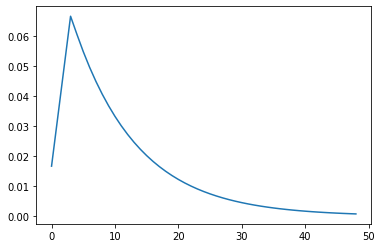

In [ ]:
# Sanity Checks
plt.plot([lr_curve(i) for i in range(1,50)])

In [ ]:
# Setup Tuner (Hyperband)
def tuner_buildHB(model,id):
  tuner = kt.Hyperband(model,
                      objective = 'val_loss',
                      max_epochs = 5,
                      factor = 5,
                      distribution_strategy=strategy,
                      seed = SEED,
                      directory = 'gs://cz4042nn',
                      project_name = id
                       ) 
  return tuner 

In [ ]:
# Tuning
def tuner_train(tuner,training_dataset,val_dataset):
  steps_per_epoch=(0.675*len(df)) // BATCH_SIZE
  validation_steps=(0.225*len(df)) // BATCH_SIZE
  start = time.time() 
  tuner.search(
      training_dataset,
      steps_per_epoch=steps_per_epoch,
      validation_data=val_dataset,
      validation_steps=validation_steps,
      epochs = 5, 
      batch_size=BATCH_SIZE,
      callbacks = [ClearTrainingOutput(),LearningRateScheduler(lr_curve)])
  end = time.time()
  TT = round((end - start),3)
  print('Time Taken: ', TT,'s')

In [ ]:
# Get the optimal hyperparameters 
def get_optimalHP(bestHP):
  print('Optimal Neurons          = ', bestHP.get('units1'))
  print('Optimal L2               = ', bestHP.get('l2'))
  print('Optimal Optimizer        = ', bestHP.get('optimizer'))
  print('Optimal Layers           = ', bestHP.get('num_layers'))
  print('Optimal Learning Rate    = ', bestHP.get('learning_rate'))
  print('Optimal Dropout Rate     = ', bestHP.get('rate1'))

## Run Tuner

### Hyperband

In [ ]:
# Build (Hyberband)
tuner_testHB = tuner_buildHB(model_buildHP_2,'testHB8')

INFO:tensorflow:Reloading Oracle from existing project gs://cz4042nn/testHB8/oracle.json


INFO:tensorflow:Reloading Oracle from existing project gs://cz4042nn/testHB8/oracle.json


115261440/115255328 [==============================] - 1s 0us/step


In [ ]:
# Train (Hyper Band)
tuner_train(tuner_testHB,training_dataset,val_dataset)

Trial 9 Complete [00h 30m 02s]
val_loss: 11.864209175109863

Best val_loss So Far: 7.21470308303833
Total elapsed time: 02h 26m 58s
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


Time Taken:  8076.789 s


In [ ]:
# Get Best (Hyper Band)
bestHP_testHB = tuner_testHB.get_best_hyperparameters(num_trials = 1)[0]

In [ ]:
# Optimal Result (Hyper Band)
get_optimalHP(bestHP_testHB) # May need to change the function to get all the print value out

Optimal Neurons          =  512
Optimal L2               =  1e-06
Optimal Optimizer        =  rms
Optimal Layers           =  1
Optimal Learning Rate    =  0.001
Optimal Dropout Rate     =  0.0


In [ ]:
# Optimal Result (Hyper Band)
get_optimalHP(bestHP_testHB) 

Optimal Neurons          =  256
Optimal L2               =  0.001
Optimal Optimizer        =  sgd_m
Optimal Layers           =  1
Optimal Learning Rate    =  0.001
Optimal Dropout Rate     =  0.30000000000000004


In [ ]:
# Return top 10 best trials
print(tuner_testHB.results_summary(num_trials=10)) 

Results summary
Results in gs://cz4042nn/testHB8
Showing 10 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
units1: 256
learning_rate: 0.001
rate1: 0.30000000000000004
l2: 0.001
optimizer: sgd_m
num_layers: 1
tuner/epochs: 5
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 7.21470308303833
Trial summary
Hyperparameters:
units1: 1024
learning_rate: 0.0001
rate1: 0.4
l2: 1e-06
optimizer: sgd_m
num_layers: 3
tuner/epochs: 5
tuner/initial_epoch: 1
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 5f2193f4647e7b8db033b1675110c215
Score: 10.57912826538086
Trial summary
Hyperparameters:
units1: 512
learning_rate: 0.01
rate1: 0.1
l2: 1e-05
optimizer: rms
num_layers: 3
tuner/epochs: 5
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 11.864209175109863
Trial summary
Hyperparameters:
units1: 1024
learning_rate: 0.0001
rate1: 0.4
l2: 1e-06
optimizer: sgd_m
num_layers: 3
tuner/epochs: 1
tuner/initial_epoch: 0
tuner/bracket: 1
tuner/roun

In [ ]:
# Get the top 10 best trials' hyperparameters from hyperband technique
bestTenTrialsHB = tuner_testHB.get_best_hyperparameters(num_trials = 10)
list_trial = []
for trial in bestTenTrialsHB:
  list_trial.append(trial.values)
df = pd.DataFrame(list_trial)
df.index += 1
df.head()

,units1,learning_rate,rate1,l2,optimizer,num_layers,tuner/epochs,tuner/initial_epoch,tuner/bracket,tuner/round,tuner/trial_id
1,256,0.001000,0.3,0.001000,sgd_m,1,5,0,0,0,NaN
2,1024,0.000100,0.4,0.000001,sgd_m,3,5,1,1,1,5f2193f4647e7b8db033b1675110c215
3,512,0.010000,0.1,0.000010,rms,3,5,0,0,0,NaN
4,1024,0.000100,0.4,0.000001,sgd_m,3,1,0,1,0,NaN
5,256,0.000001,0.2,0.000001,adam,1,1,0,1,0,NaN


# Optimal Baseline Model (Refer to baseline_optimised.ipynb)

# Focal Loss Model

In [ ]:
def lr_curve(epoch):
  if (epoch < 5):
    return 1e-6 + epoch*((1e-1-1e-6)/6)

  initial_lrate = 1e-1
  k = 0.1
  lrate = initial_lrate * math.exp(-k*epoch)

  return lrate

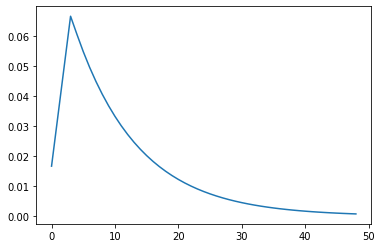

In [ ]:
plt.plot([lr_curve(i) for i in range(1,50)])

In [ ]:
def lr_curve_alt(epoch):

  initial_lrate = 1e-1
  k = 0.1
  lrate = initial_lrate * math.exp(-k*(epoch+20))

  return lrate

In [ ]:
def build_model(lr, losses, metrics):
  SEED = 0

  base_model = efn.EfficientNetB5(include_top=False, weights='noisy-student')
  
  for layer in base_model.layers:
      layer.trainable = True

  model_input = Input(shape=[IMAGE_SIZE[0],IMAGE_SIZE[1],3])
  x = base_model(model_input)
  x = GlobalAveragePooling2D()(x)
  
  x = Dense(512, kernel_regularizer=l2(0.001), activation='relu')(x)
  x = Dropout(rate = 0.3, seed = SEED)(x)

  y1 = Dense(256, kernel_regularizer=l2(0.001), activation='relu')(x)
  y1 = Dropout(rate = 0.3, seed = SEED)(y1)
  
  y2 = Dense(256, kernel_regularizer=l2(0.001), activation='relu')(x)
  y2 = Dropout(rate = 0.3, seed = SEED)(y2)
  
  y1 = Dense(163, activation='softmax', name='make_id')(y1)
  y2 = Dense(1716, activation='softmax', name='model_id')(y2)
  
  model = Model(inputs=model_input, outputs=[y1, y2])
  
  model.compile(loss=losses, optimizer=SGD(lr=lr, momentum=0.9), metrics=metrics)
  
  return model

In [ ]:
with strategy.scope():
  model = build_model(
            0.001,
            [ tfa.losses.SigmoidFocalCrossEntropy(reduction=tf.keras.losses.Reduction.AUTO),  tfa.losses.SigmoidFocalCrossEntropy(reduction=tf.keras.losses.Reduction.AUTO)], 
            {'make_id':'accuracy', 'model_id':'accuracy'}
    )
model.summary()

115261440/115255328 [==============================] - 1s 0us/step
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
efficientnet-b5 (Functional)    (None, None, None, 2 28513520    input_2[0][0]                    
__________________________________________________________________________________________________
global_average_pooling2d (Globa (None, 2048)         0           efficientnet-b5[0][0]            
__________________________________________________________________________________________________
dense (Dense)                   (None, 512)          1049088     global_average_pooling2d[0][0]   
____________________

### First 20 Epochs with Focal Loss Function

In [ ]:
with strategy.scope():
  checkpoint = ModelCheckpoint('/content/drive/My Drive/CZ4042 Project/model_checkpoints/ckpt-{epoch}-focal.h5', 
                              monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=True, mode='min')
  steps_per_epoch=(0.675*len(df)) // BATCH_SIZE
  validation_steps=(0.225*len(df)) // BATCH_SIZE

  history = model.fit(
      training_dataset,
      steps_per_epoch=steps_per_epoch,
      validation_data=val_dataset,
      validation_steps=validation_steps,
      epochs=20,
      callbacks=[checkpoint, LearningRateScheduler(lr_curve)]
  )

Epoch 1/20
   2/1442 [..............................] - ETA: 1:53 - loss: 4.6222 - make_id_loss: 1.2555 - model_id_loss: 1.8643 - make_id_accuracy: 0.0078 - model_id_accuracy: 0.0000e+00  WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0132s vs `on_train_batch_end` time: 0.1379s). Check your callbacks.


1442/1442 [==============================] - ETA: 0s - loss: 4.6274 - make_id_loss: 1.2639 - model_id_loss: 1.8611 - make_id_accuracy: 0.0057 - model_id_accuracy: 4.7677e-04WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0096s vs `on_test_batch_end` time: 0.0537s). Check your callbacks.


1442/1442 [==============================] - 289s 201ms/step - loss: 4.6274 - make_id_loss: 1.2639 - model_id_loss: 1.8611 - make_id_accuracy: 0.0057 - model_id_accuracy: 4.7677e-04 - val_loss: 4.9084 - val_make_id_loss: 1.4196 - val_model_id_loss: 1.9864 - val_make_id_accuracy: 0.0043 - val_model_id_accuracy: 8.7891e-04
Epoch 2/20
1442/1442 [==============================] - 294s 204ms/step - loss: 3.9097 - make_id_loss: 1.0931 - model_id_loss: 1.8428 - make_id_accuracy: 0.0444 - model_id_accuracy: 0.0017 - val_loss: 4.0244 - val_make_id_loss: 1.3808 - val_model_id_loss: 2.0597 - val_make_id_accuracy: 0.0678 - val_model_id_accuracy: 0.0025
Epoch 3/20
1442/1442 [==============================] - 294s 204ms/step - loss: 2.9212 - make_id_loss: 0.9448 - model_id_loss: 1.6955 - make_id_accuracy: 0.1083 - model_id_accuracy: 0.0065 - val_loss: 2.6807 - val_make_id_loss: 0.9467 - val_model_id_loss: 1.6083 - val_make_id_accuracy: 0.1735 - val_model_id_accuracy: 0.0190
Epoch 4/20
1442/1442 [===

In [ ]:
# convert the history.history dict to a pandas DataFrame:     
hist_df = pd.DataFrame(history.history) 

# or save to csv: 
hist_csv_file = '/content/drive/My Drive/CZ4042 Project/history_focal_1.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

In [ ]:
model.save('/content/drive/My Drive/CZ4042 Project/model_checkpoints/first20_focal.h5')

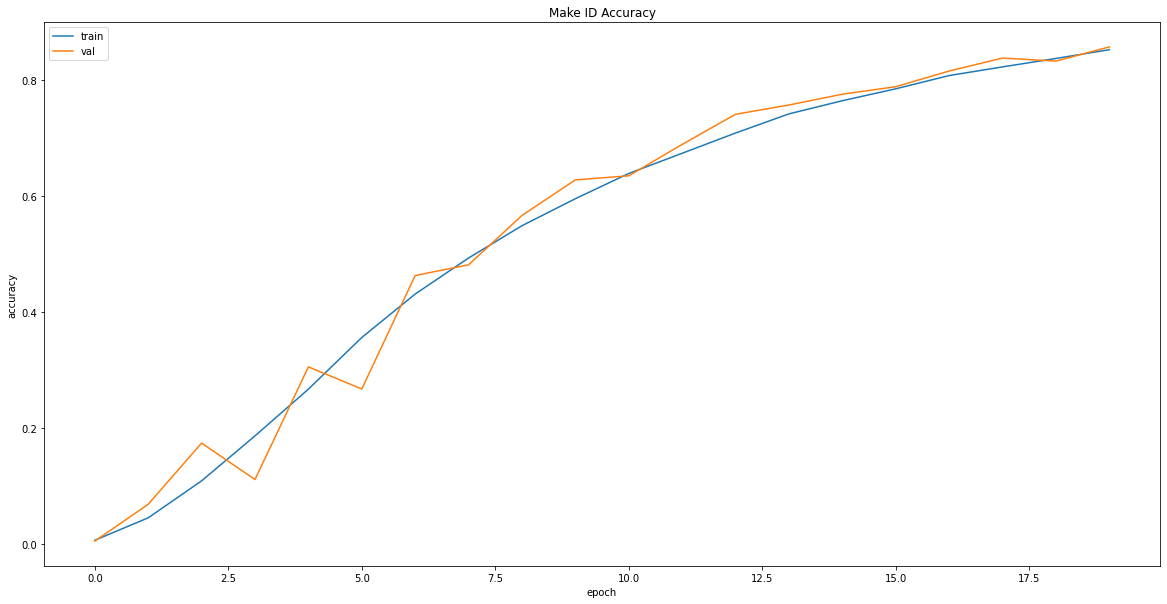

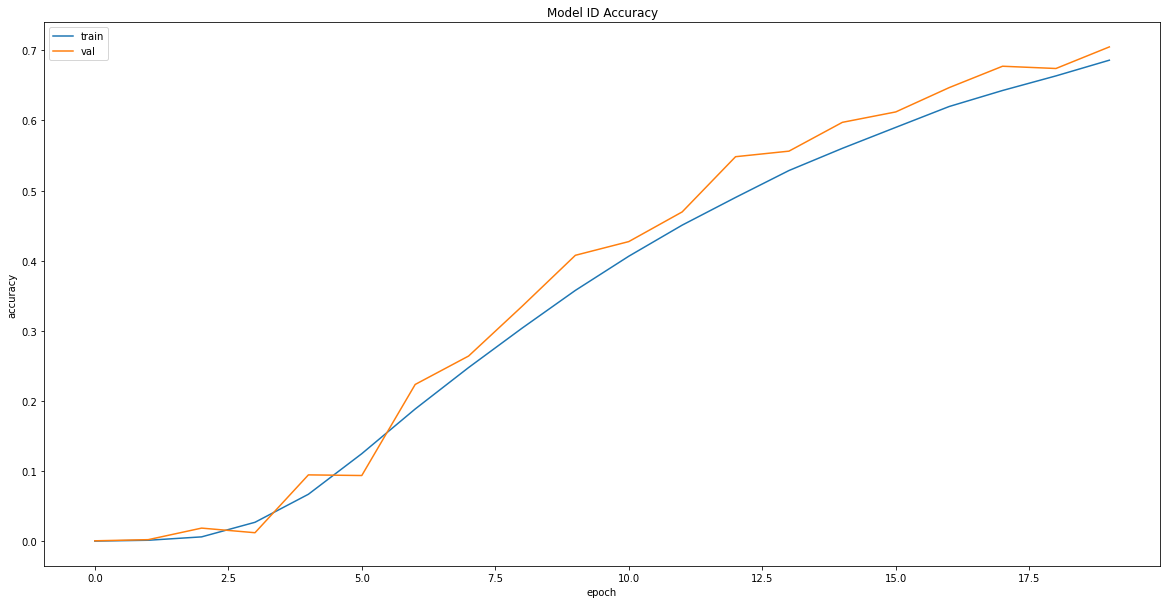

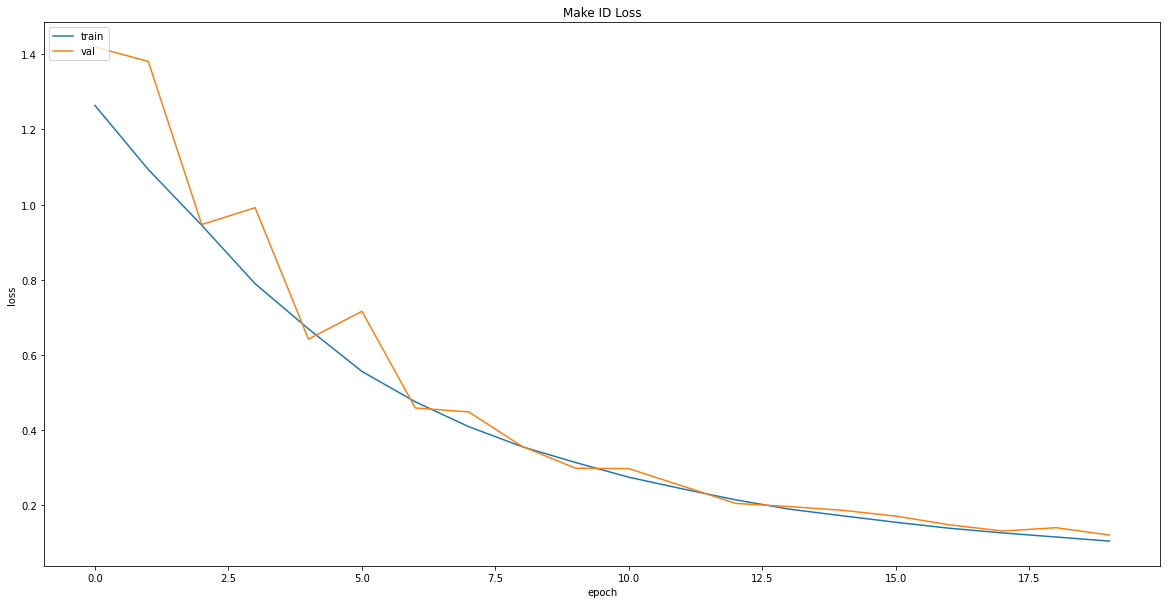

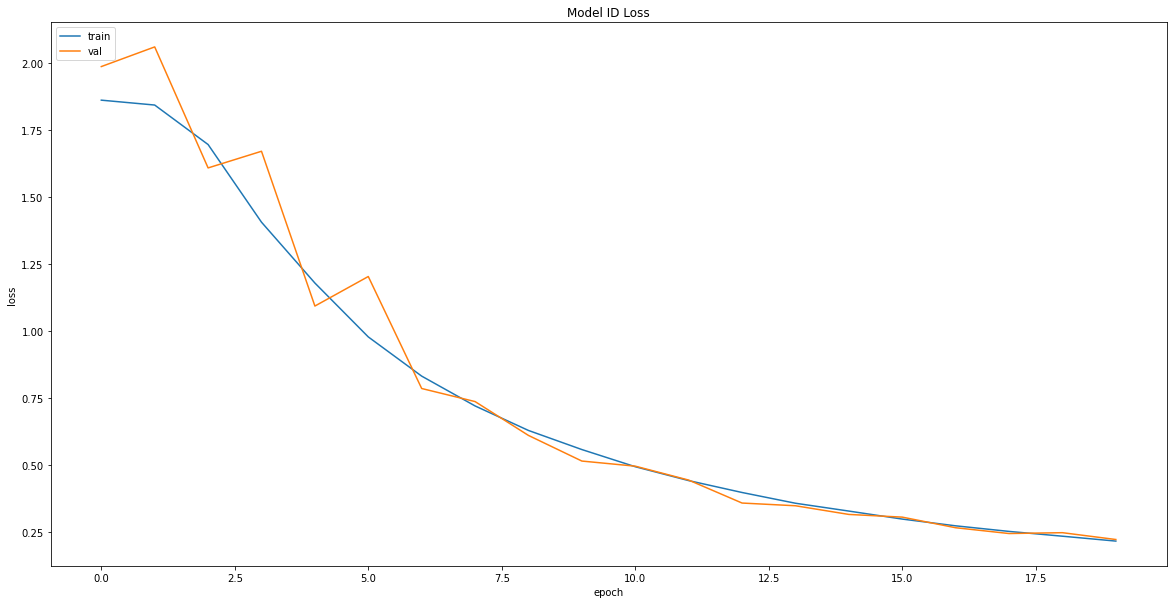

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(history.history['make_id_accuracy'])
plt.plot(history.history['val_make_id_accuracy'])
plt.title('Make ID Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['model_id_accuracy'])
plt.plot(history.history['val_model_id_accuracy'])
plt.title('Model ID Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['make_id_loss'])
plt.plot(history.history['val_make_id_loss'])
plt.title('Make ID Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['model_id_loss'])
plt.plot(history.history['val_model_id_loss'])
plt.title('Model ID Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### 21 to 40 Epochs with Focal Loss Function

In [ ]:
with strategy.scope():
  model = tf.keras.models.load_model('/content/drive/My Drive/CZ4042 Project/model_checkpoints/first20_focal.h5')

In [ ]:
checkpoint = ModelCheckpoint('/content/drive/My Drive/CZ4042 Project/model_checkpoints/ckpt-{epoch} + 20 -focal.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')

history = model.fit(
    training_dataset,
    steps_per_epoch=(0.675*len(df)) // BATCH_SIZE,
    validation_data=val_dataset,
    validation_steps=(0.225*len(df)) // BATCH_SIZE,
    epochs=20,
    callbacks=[checkpoint, LearningRateScheduler(lr_curve_alt)]
)

Epoch 1/20
   2/1442 [..............................] - ETA: 1:55 - loss: 0.3465 - make_id_loss: 0.0844 - model_id_loss: 0.1621 - make_id_accuracy: 0.8672 - model_id_accuracy: 0.7422WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0132s vs `on_train_batch_end` time: 0.1386s). Check your callbacks.


1442/1442 [==============================] - ETA: 0s - loss: 0.3843 - make_id_loss: 0.0907 - model_id_loss: 0.1944 - make_id_accuracy: 0.8711 - model_id_accuracy: 0.7127WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0090s vs `on_test_batch_end` time: 0.0530s). Check your callbacks.



Epoch 00001: val_loss improved from inf to 0.41738, saving model to /content/drive/My Drive/CZ4042 Project/model_checkpoints/ckpt-1 + 20 -focal.h5
1442/1442 [==============================] - 298s 207ms/step - loss: 0.3843 - make_id_loss: 0.0907 - model_id_loss: 0.1944 - make_id_accuracy: 0.8711 - model_id_accuracy: 0.7127 - val_loss: 0.4174 - val_make_id_loss: 0.1140 - val_model_id_loss: 0.2048 - val_make_id_accuracy: 0.8625 - val_model_id_accuracy: 0.7226
Epoch 2/20
1442/1442 [==============================] - ETA: 0s - loss: 0.3654 - make_id_loss: 0.0842 - model_id_loss: 0.1836 - make_id_accuracy: 0.8814 - model_id_accuracy: 0.7248
Epoch 00002: val_loss improved from 0.41738 to 0.40452, saving model to /content/drive/My Drive/CZ4042 Project/model_checkpoints/ckpt-2 + 20 -focal.h5
1442/1442 [==============================] - 297s 206ms/step - loss: 0.3654 - make_id_loss: 0.0842 - model_id_loss: 0.1836 - make_id_accuracy: 0.8814 - model_id_accuracy: 0.7248 - val_loss: 0.4045 - val_ma

In [ ]:
# convert the history.history dict to a pandas DataFrame:     
hist_df = pd.DataFrame(history.history) 

# or save to csv: 
hist_csv_file = '/content/drive/My Drive/CZ4042 Project/history_focal_2.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

In [ ]:
model.save('/content/drive/My Drive/CZ4042 Project/model_checkpoints/final_focal.h5')

###plot accuracies Focal Loss

In [ ]:
hist = pd.read_csv('/content/drive/MyDrive/CZ4042 Project/Final Baseline Model/history_focal_final.csv')
hist.head()

,loss,make_id_loss,model_id_loss,make_id_accuracy,model_id_accuracy,val_loss,val_make_id_loss,val_model_id_loss,val_make_id_accuracy,val_model_id_accuracy,lr
0,4.627375,1.263928,1.861056,0.005678,0.000477,4.908360,1.419618,1.986365,0.004264,0.000879,0.000001
1,3.909679,1.093148,1.842841,0.044437,0.001669,4.024375,1.380831,2.059698,0.067839,0.002507,0.016668
2,2.921184,0.944788,1.695516,0.108302,0.006480,2.680735,0.946690,1.608291,0.173535,0.018978,0.033334
3,2.284394,0.789122,1.405862,0.185961,0.027273,2.744900,0.991565,1.670407,0.110579,0.012402,0.050000
4,1.943572,0.668826,1.178892,0.266665,0.067214,1.841988,0.641615,1.093036,0.305143,0.094824,0.066667


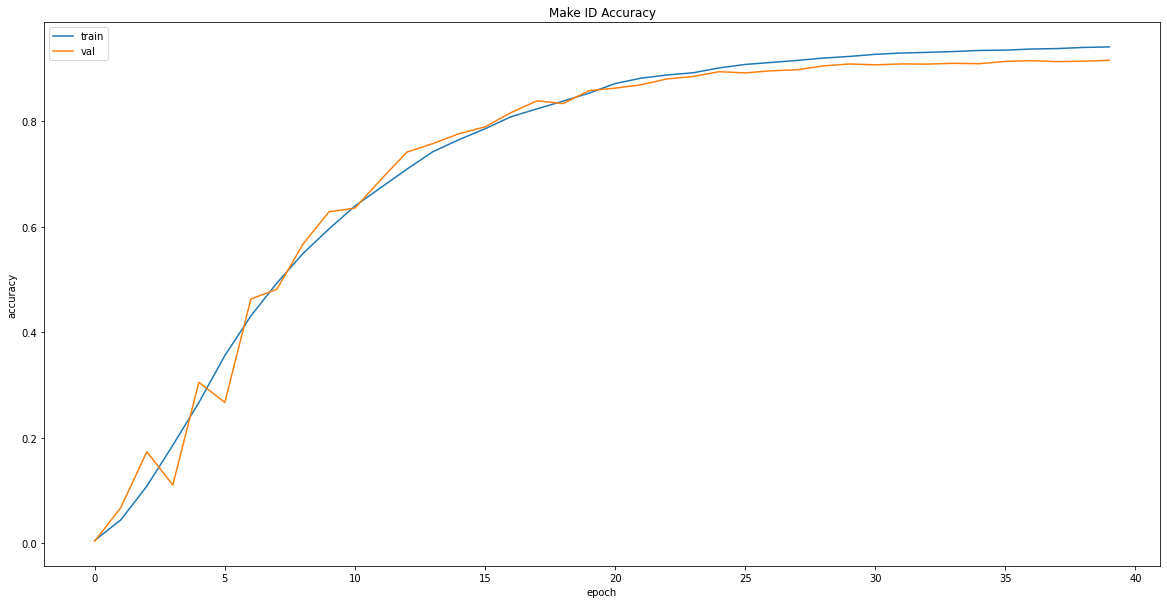

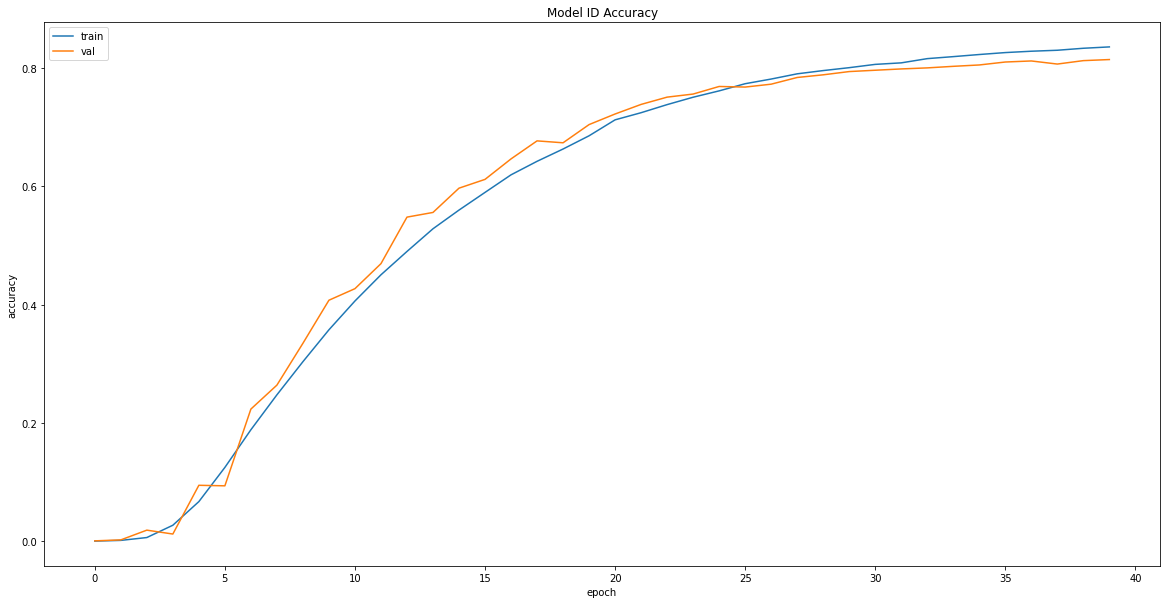

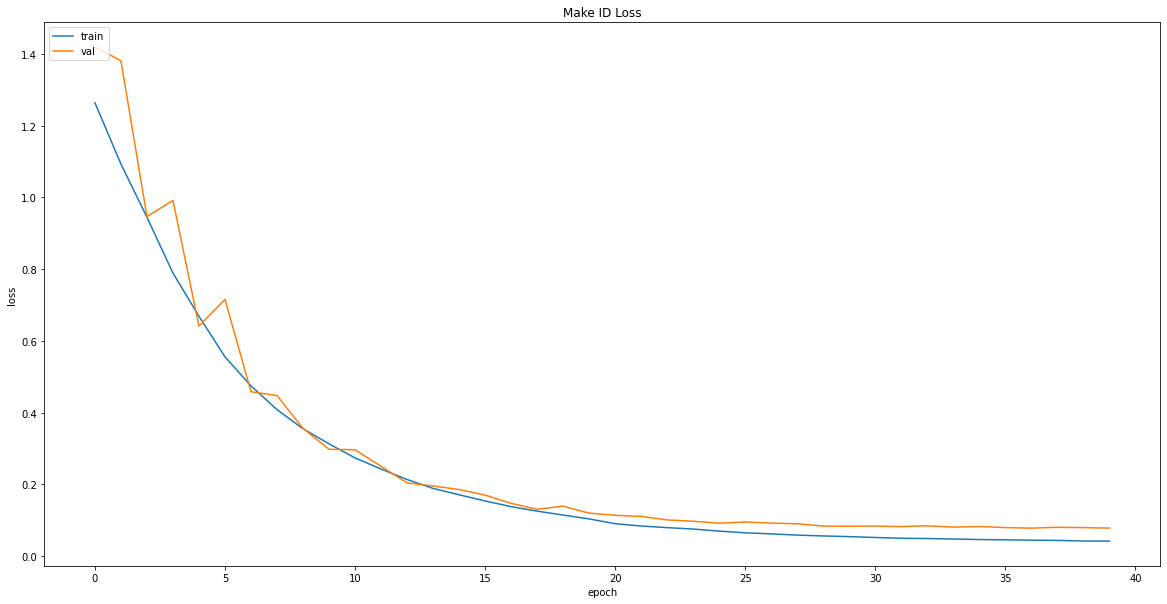

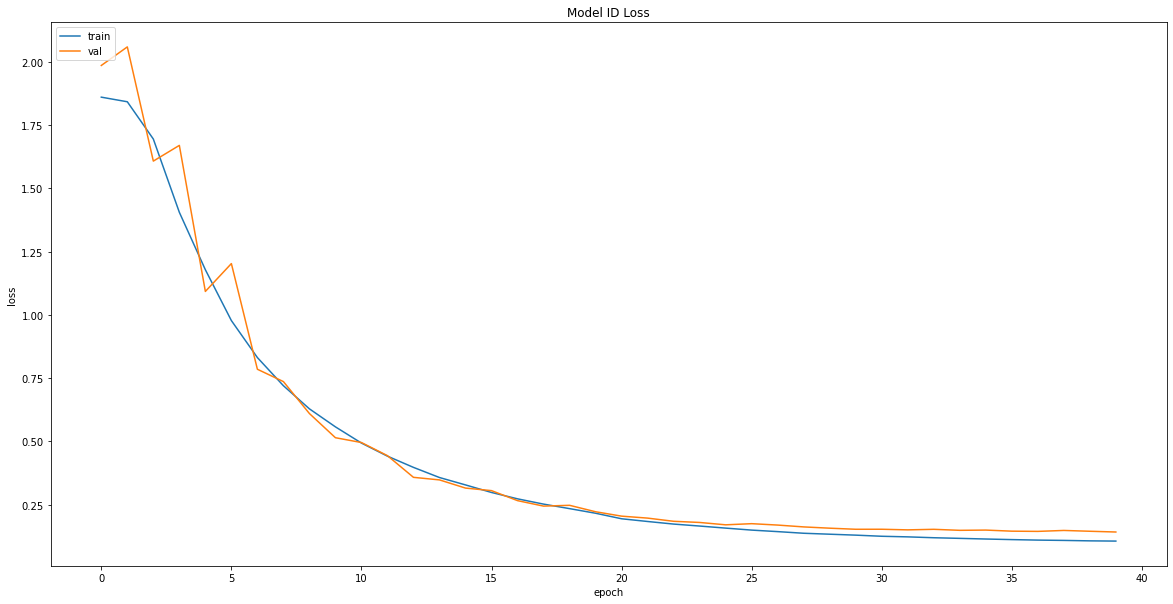

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(hist['make_id_accuracy'].values)
plt.plot(hist['val_make_id_accuracy'].values)
plt.title('Make ID Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(hist['model_id_accuracy'].values)
plt.plot(hist['val_model_id_accuracy'].values)
plt.title('Model ID Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(hist['make_id_loss'].values)
plt.plot(hist['val_make_id_loss'].values)
plt.title('Make ID Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(hist['model_id_loss'].values)
plt.plot(hist['val_model_id_loss'].values)
plt.title('Model ID Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Evaluate model on Testset

In [ ]:
def custom_image_generator(lists, batch_size, mode="train", aug=None):
    while True:
        images = []
        make_ids = []
        model_ids = []
        
        while len(images) < batch_size:
            random_idx = randrange(len(lists[0]))
            img = load_img(lists[0][random_idx], target_size=(IMAGE_SIZE[0], IMAGE_SIZE[1]))
            img = img_to_array(img)
            # TODO: Center crop instead of resize
            images.append(img)
            make_ids.append(lists[1][random_idx])
            model_ids.append(lists[2][random_idx])
        
        labels = [np.array(make_ids),np.array(model_ids)]
        
        if aug:
            (images, labels) = next(aug.flow(np.array(images), labels, batch_size=batch_size))
        
        yield np.array(images),  labels 

def read_tfrecord(example):
  features = {
      "image": tf.io.FixedLenFeature([], tf.string),
      "make_id": tf.io.FixedLenFeature([], tf.int64),
      "make_id_oh": tf.io.VarLenFeature(tf.float32),
      "model_id": tf.io.FixedLenFeature([], tf.int64),
      "model_id_oh": tf.io.VarLenFeature(tf.float32)
  }

  feature = tf.io.parse_single_example(example, features)

  image = tf.image.decode_jpeg(feature['image'], channels=3)
  image = tf.image.convert_image_dtype(image, tf.float32)
  image = tf.image.resize(image, [*IMAGE_SIZE])

  make_id_oh = tf.sparse.to_dense(feature['make_id_oh'])
  make_id_oh = tf.reshape(make_id_oh, [163])
  print(make_id_oh.shape)

  model_id_oh = tf.sparse.to_dense(feature['model_id_oh'])
  model_id_oh = tf.reshape(model_id_oh, [1716])
  print(model_id_oh.shape)

  return image, {'make_id': make_id_oh, 'model_id': model_id_oh}

def augment(image, labels):
  image = tf.image.random_crop(image, size=[64, 224, 224, 3]) # Random crop back
  image = tf.image.random_brightness(image, max_delta=0.6) # Random brightness
  image = tf.image.random_flip_left_right(image)
  image = tf.image.random_contrast(image, 0.2, 0.6)
  # image = tf.image.random_jpeg_quality(image, 10, 80)
  image = tf.image.random_saturation(image, 5, 35)
  image = tf.image.random_hue(image, 0.2)
  print(labels)

  return image, labels

def normalise(image, labels):
  image = tf.cast(image, tf.float32) * (1. / 255)
  print(labels)

  return image, labels

def get_x(image, labels):
  return image

def get_y(image, labels):
  return labels

In [ ]:
IMAGE_SIZE = [224,224]
BATCH_SIZE = 64
GCS_PATH = 'gs://compcars'
tfrecord_test_dir = GCS_PATH + '/test'

option_no_order = tf.data.Options()
option_no_order.experimental_deterministic = False
AUTO = tf.data.experimental.AUTOTUNE

test_path = tf.io.gfile.glob(tfrecord_test_dir + "/*.tfrec")

test_dataset = tf.data.TFRecordDataset(test_path, num_parallel_reads=AUTO)
test_dataset = test_dataset.with_options(option_no_order)
test_dataset = test_dataset.map(read_tfrecord, num_parallel_calls=AUTO)
test_dataset = test_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.map(augment, num_parallel_calls=AUTO)
test_dataset = test_dataset.map(normalise, num_parallel_calls=AUTO)
test_dataset = test_dataset.cache()
test_dataset = test_dataset.prefetch(AUTO)

(163,)
(1716,)
{'make_id': <tf.Tensor 'args_1:0' shape=(None, 163) dtype=float32>, 'model_id': <tf.Tensor 'args_2:0' shape=(None, 1716) dtype=float32>}
{'make_id': <tf.Tensor 'args_1:0' shape=(None, 163) dtype=float32>, 'model_id': <tf.Tensor 'args_2:0' shape=(None, 1716) dtype=float32>}


In [ ]:
with strategy.scope():
  model = tf.keras.models.load_model('/content/drive/MyDrive/CZ4042 Project/model_checkpoints/final_focal.h5')

In [ ]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(test_dataset)
print("test loss, test acc:", results)

Evaluate on test data
215/215 [==============================] - 16s 75ms/step - loss: 0.3584 - make_id_loss: 0.0957 - model_id_loss: 0.1853 - make_id_accuracy: 0.9073 - model_id_accuracy: 0.8039
test loss, test acc: [0.35841530561447144, 0.09567858278751373, 0.18529893457889557, 0.9073401093482971, 0.8039244413375854]
